In [23]:
from dotenv import load_dotenv
load_dotenv()

True

In [24]:
from typing import Literal
from datetime import datetime
from pydantic import BaseModel, Field
from langchain_core.tools import tool

@tool
def write_email(to: str, subject: str, content: str) -> str:
    """Write an email to the given recipient with the given subject and content."""
    return f"Email sent to {to} with subject {subject} and content: {content}"

@tool
def schedule_meeting(attendees: list[str], subject: str, duration_minutes: int, preferred_day: datetime, start_time: int) -> str:
    """Schedule a meeting"""
    date_str = preferred_day.strftime("%A, %B %d, %Y")
    return f"Meeting '{subject}' scheduled for {date_str} from {start_time}:00 to {start_time + duration_minutes // 60}:{duration_minutes % 60} with {attendees}"


@tool
def check_calendar_availability(day: str) -> str:
    """Check the availability of the calendar on the given day"""
    return f"Available slots on {day}: 9:00AM, 2:00PM, 4:00PM"

@tool
class Done(BaseModel):
    done: bool

In [25]:
# Triaging router
from langgraph.graph import MessagesState


class State(MessagesState):
    email_input: dict
    classification_decision: Literal["ignore", "respond", "notify"]

In [26]:
from pydantic import BaseModel, Field
from src.personal_agent.prompts import triage_system_prompt, triage_user_prompt, default_triage_instructions, default_background
from src.personal_agent.utils import parse_email, format_email_markdown
from langchain.chat_models import init_chat_model
from langgraph.graph import END
from langgraph.types import Command


In [27]:
from rich.markdown import Markdown
Markdown(triage_system_prompt)

< Role > Your role is to triage incoming emails based upon instructs and background information below. </ Role >   

< Background > {background}. </ Background >                                                                       

< Instructions > Categorize each email into one of three categories:                                               

 1 IGNORE - Emails that are not worth responding to or tracking                                                    
 2 NOTIFY - Important information that worth notification but doesn't require a response                           
 3 RESPOND - Emails that need a direct response Classify the below email into one of these categories. </          
   Instructions >                                                                                                  

< Rules > {triage_instructions} </ Rules >

In [59]:
class RouterSchema(BaseModel):
    """Schema for the router"""
    reasoning: str = Field(description="Step by step reasoning for the classification decision")

    classification: Literal["ignore", "respond", "notify"] = Field(
        description="The classification of an email: 'ignore' for irrelevant emails, 'respond' for emails that need a reply and 'notify' for important information that doesn't need a response")

llm = init_chat_model(model="gpt-4o-mini", temperature=0)
llm_router = llm.with_structured_output(RouterSchema)

def triage_router(state: State) -> Command[Literal["response_agent", "__end__"]]:
    """Analyze the email and decide whether to ignore, respond or notify"""
    author, to, subject, email_thread = parse_email(state["email_input"])
    system_prompt = triage_system_prompt.format(
        background=default_background,
        triage_instructions=default_triage_instructions
    )
    user_prompt = triage_user_prompt.format(
        author=author,
        to=to,
        subject=subject,
        email_thread=email_thread
    )
    messages = [
        {"role": "system", "content": system_prompt},
        {"role": "user", "content": user_prompt}
    ]

    response = llm_router.invoke(messages)

    if response.classification == "ignore":
        print("Classification: IGNORE. This email will be ignored.")
        goto = END
        update = {"classification_decision": 'ignore'}
    elif response.classification == "respond":
        print("Classification: RESPOND. This email will be replied to.")
        goto = "response_agent"
        update = {
            messages: [
                {
                    "role": "user",
                    "content": f"Respond to the following email: {format_email_markdown(subject, author, to, email_thread)}"
                }
            ],
            "classification_decision": "respond"
        }
    elif response.classification == "notify":
        print("Classification: NOTIFY. This email will be notified.")
        goto = END
        update = {
            "classification_decision": "notify"
        }
    else:
        raise ValueError("Invalid classification")
    return Command(goto=goto, update=update)

In [60]:
from src.personal_agent.prompts import agent_system_prompt, default_response_preferences, default_cal_preferences
from src.personal_agent.tools.default.prompt_templates import AGENT_TOOLS_PROMPT

In [61]:
tools = [write_email, schedule_meeting, check_calendar_availability]
tools_by_name = {tool.name: tool for tool in tools}

llm = init_chat_model(model="gpt-4o-mini", temperature=0)
llm_with_tools = llm.bind_tools(tools, tool_choice="any")

def llm_call(state: State):
    """LLM decides whether to call a tool or not"""

    return {
        "messages": [
            llm_with_tools.invoke(
                [
                    {"role": "system", "content": agent_system_prompt.format(
                        tools_prompt=AGENT_TOOLS_PROMPT,
                        background=default_background,
                        response_preferences=default_response_preferences,
                        cal_preferences=default_cal_preferences
                    )}
                ]
                + state["messages"]
            )
        ]
    }

In [62]:
def tool_handler(state: State):
    """Handle the tool call"""

    result = []

    for tool_call in state["messages"][-1].tool_calls:
        tool = tools_by_name[tool_call["name"]]
        observation = tool.invoke(tool_call["args"])
        result.append(
            {
                "role": "tool",
                "content": observation,
                "tool_call_id": tool_call["id"]
            }
        )
    return {"messages": result}


In [63]:
def should_continue(state: State) -> Literal["tool_handler", "__end__"]:
    """Route to tool handler, or end if Done tool called."""
    
    # Get the last message
    messages = state["messages"]
    last_message = messages[-1]
    
    # Check if it's a Done tool call
    if last_message.tool_calls:
        for tool_call in last_message.tool_calls: 
            if tool_call["name"] == "Done":
                return END
            else:
                return "tool_handler"

In [64]:
from langgraph.graph import StateGraph, START, END
from src.personal_agent.utils import show_graph

# Build workflow
overall_workflow = StateGraph(State)

# Add nodes
overall_workflow.add_node("llm_call", llm_call)
overall_workflow.add_node("tool_handler", tool_handler)

# Add edges
overall_workflow.add_edge(START, "llm_call")
overall_workflow.add_conditional_edges(
    "llm_call",
    should_continue,
    {
        "tool_handler": "tool_handler",
        END: END,
    },
)
overall_workflow.add_edge("tool_handler", "llm_call")

# Compile the agent
agent = overall_workflow.compile()

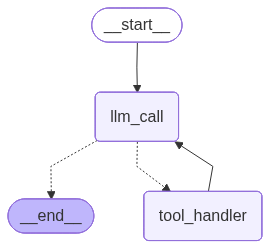

In [65]:
show_graph(agent)

In [66]:
overall_workflow = (
    StateGraph(State)
    .add_node("triage_router", triage_router)
    .add_node("response_agent", agent)
    .add_edge(START, "triage_router")
).compile()

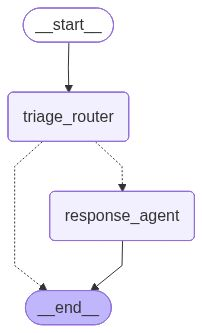

In [67]:
show_graph(overall_workflow)

In [68]:
email_input = {
    "author": "System Admin <sysadmin@company.com>",
    "to": "Development Team <dev@company.com>",
    "subject": "Scheduled maintenance - database downtime",
    "email_thread": "Hi team,\n\nThis is a reminder that we'll be performing scheduled maintenance on the production database tonight from 2AM to 4AM EST. During this time, all database services will be unavailable.\n\nPlease plan your work accordingly and ensure no critical deployments are scheduled during this window.\n\nThanks,\nSystem Admin Team"
}

# Run the agent
response = overall_workflow.invoke({"email_input": email_input})
for m in response["messages"]:
    m.pretty_print()

Classification: NOTIFY. This email will be notified.
